In [1]:
%run ../0-utils/0-Base.py

Define global variables:

In [2]:
NUM_MONTH_LAGS = 16
NUM_FEATURES   = 28

Read aggregated by *card_id* data of transactions:

In [3]:
df = pd.read_feather("../data/1-feature-engineered/aggregated-transactions-by-card-id.feather"); display(df)

,card_id,month_lag,avg(authorized_flag),min(purchase_amount),avg(purchase_amount),max(purchase_amount),count,"first(purchase_year, true)","first(purchase_month, true)",min(authorized_purchase_amount),avg(authorized_purchase_amount),max(authorized_purchase_amount),min(not_authorized_purchase_amount),avg(not_authorized_purchase_amount),max(not_authorized_purchase_amount),avg(installments_-1),avg(installments_0),avg(installments_1),avg(installments_2),avg(installments_3),avg(installments_4),avg(installments_5),avg(installments_6),avg(installments_7),avg(installments_8),avg(installments_9),avg(installments_10),avg(installments_11),avg(installments_12)
0,C_ID_00007093c1,-12,1.000000,-0.572600,-0.333604,0.037176,4,2017,2,-0.572600,-0.333604,0.037176,NaN,NaN,NaN,0.0,0.0,0.500000,0.25,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C_ID_00007093c1,-11,0.700000,-0.677936,-0.571263,-0.401298,10,2017,3,-0.677936,-0.560815,-0.401298,-0.671775,-0.595641,-0.557574,0.0,0.0,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C_ID_00007093c1,-10,0.750000,-0.728876,-0.542391,0.004418,12,2017,4,-0.728876,-0.546012,0.004418,-0.671775,-0.531528,-0.311139,0.0,0.0,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044125,C_ID_fffffd5772,-1,0.900000,-0.728876,-0.692835,-0.581616,10,2018,1,-0.728876,-0.688830,-0.581616,-0.728876,-0.728876,-0.728876,0.0,0.0,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3044126,C_ID_fffffd5772,0,0.666667,-0.745405,-0.697689,-0.311139,24,2018,2,-0.745405,-0.677963,-0.311139,-0.745405,-0.737141,-0.728876,0.0,0.0,0.958333,0.00,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3044127,C_ID_fffffd5772,1,1.000000,-0.733985,-0.708490,-0.665765,3,2018,3,-0.733985,-0.708490,-0.665765,NaN,NaN,NaN,0.0,0.0,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Define a synthetic feature - *year season* - one of (winter, spring, summer, autumn):

In [4]:
df["season"] = (df["first(purchase_month, true)"] % 12 + 3) // 3

df.season = df.season.astype(np.float) # suppress MinMaxScaler warning

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def process_purchase_amounts(df):
    features = [
        "min(purchase_amount)",
        "avg(purchase_amount)",
        "max(purchase_amount)",
        
        "min(authorized_purchase_amount)",
        "avg(authorized_purchase_amount)",
        "max(authorized_purchase_amount)",
        
        "min(not_authorized_purchase_amount)",
        "avg(not_authorized_purchase_amount)",
        "max(not_authorized_purchase_amount)",
    ]
    
    X = df[features].values

    # get rid of negative values
    X += np.abs(np.nanmin(X, axis=0))
    X += 1e-8 # get rid of zeros
    X = np.log(X)
    
    X = StandardScaler().fit_transform(X)
    
    df[features] = X
    
def process_transactions_count(df):
    X = df[["count"]].values
    X = np.log(X)
    
    X = StandardScaler().fit_transform(X)
    
    df[["count"]] = X
    
def process_datetime(df):
    features = [
        "first(purchase_month, true)",
        "first(purchase_year, true)",
        "season",
    ]
    
    X = df[features].values

    X = MinMaxScaler().fit_transform(X)
    
    df[features] = X

process_datetime(df)
process_purchase_amounts(df)
process_transactions_count(df)

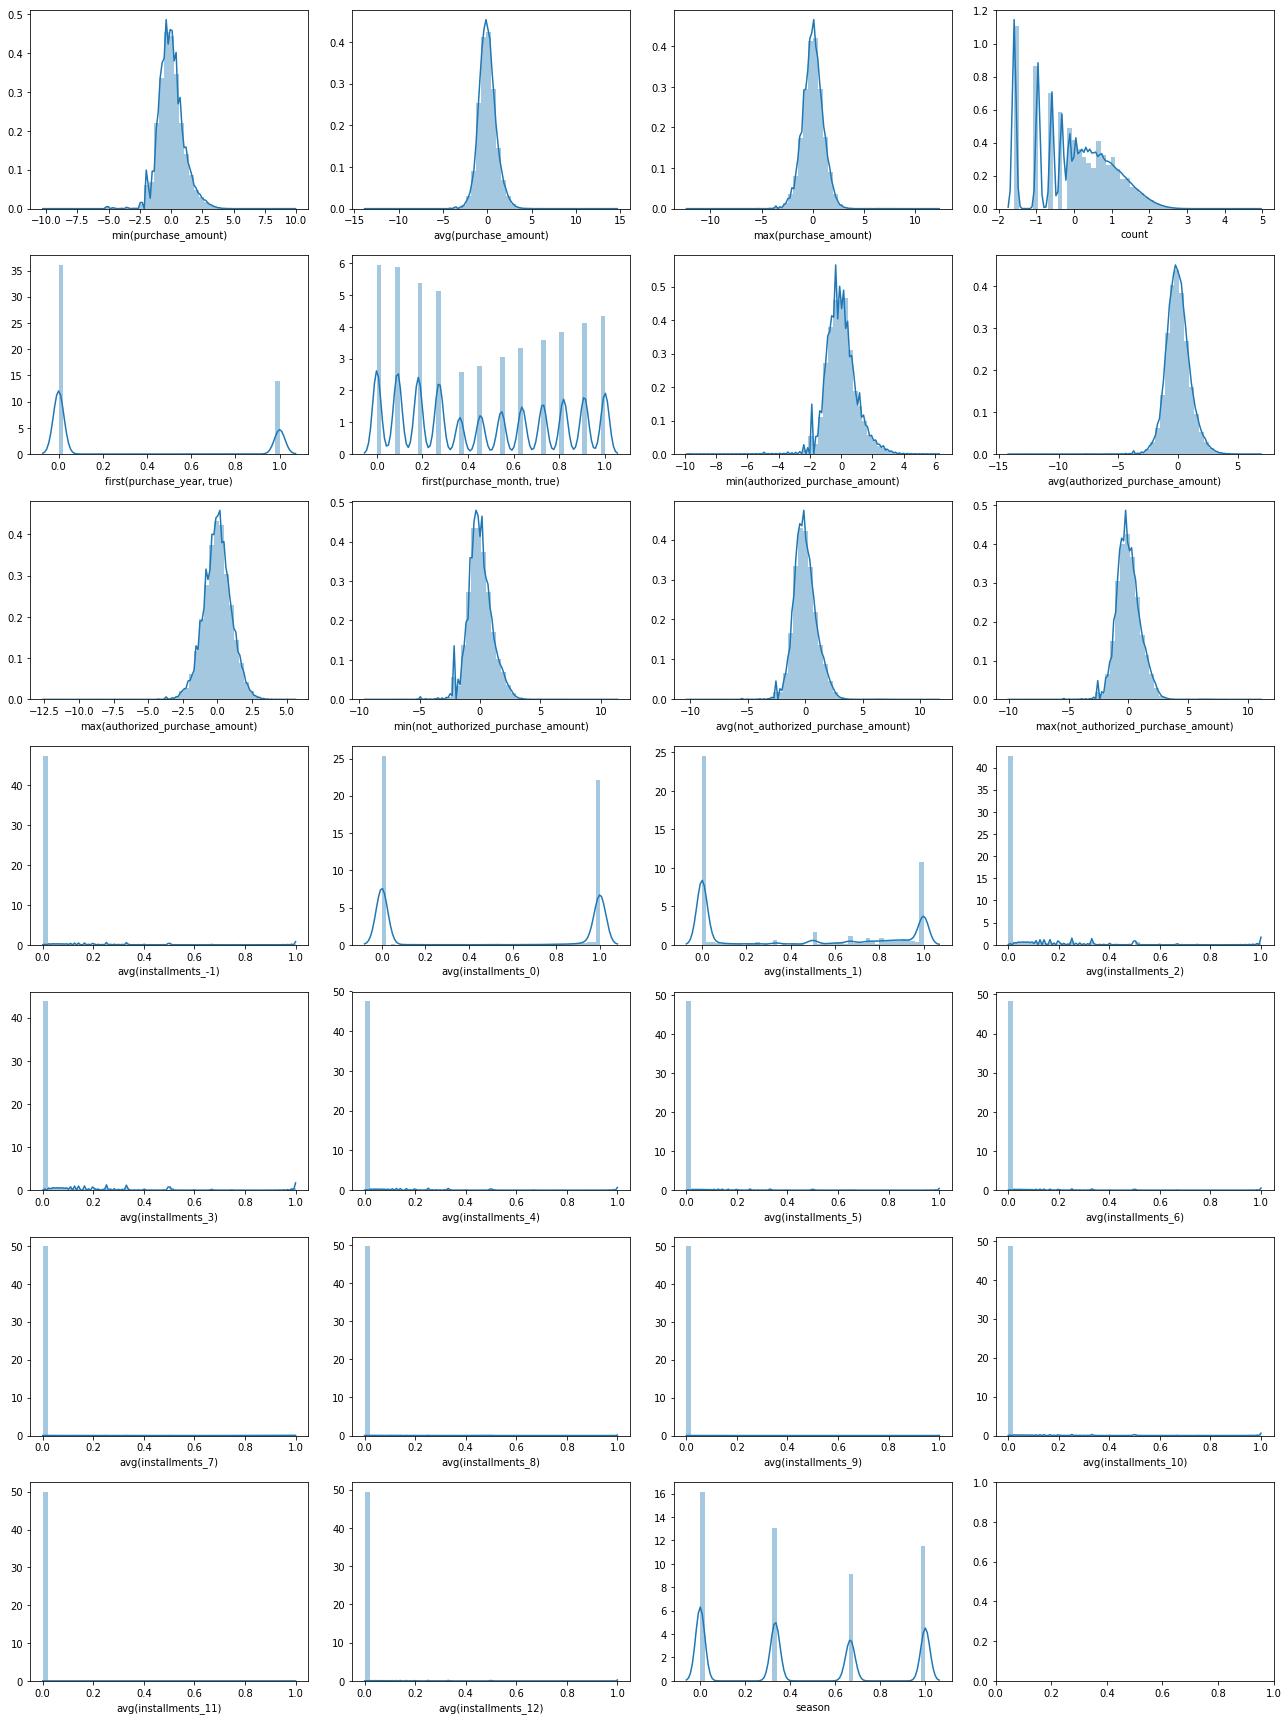

In [6]:
_, axs = plt.subplots(nrows=7, ncols=4, figsize=(18, 24))

for ax, feature in zip(axs.flat, df.columns[3:]):
    sns.distplot(df[feature].dropna(), ax=ax)

plt.tight_layout()

Read data about _train_ and _test_ customers:

In [7]:
train_customers_df = pd.read_csv("../data/raw/train.csv", usecols=("card_id", "target"))
test_customers_df  = pd.read_csv("../data/raw/test.csv",  usecols=("card_id",))
customers_df = pd.concat((train_customers_df, test_customers_df), sort=False)
customers_df = customers_df.set_index("card_id")

display(customers_df)

,target
card_id,
C_ID_92a2005557,-0.820283
C_ID_3d0044924f,0.392913
C_ID_d639edf6cd,0.688056
...,...
C_ID_21d56d950c,NaN
C_ID_6c46fc5a9d,NaN
C_ID_87e7979a5f,NaN


In [8]:
def process_customer_transactions_df(df):
    X = -999 * np.ones((NUM_MONTH_LAGS, NUM_FEATURES))
    X[df.month_lag] = df.values[:, 2:]
    X[np.isnan(X)] = -999
    return X

def process_transactions(df):
    df = df.copy()
    df.month_lag += 13 # solve the issue with negative month_lag while indexing

    X, y = [], []
    
    for card_id, customer_transactions_df in df.groupby("card_id"):
        X.append(process_customer_transactions_df(customer_transactions_df))
        y.append(customers_df.loc[card_id])

    X = np.concatenate(X).reshape(-1, NUM_MONTH_LAGS, NUM_FEATURES)
    y = np.concatenate(y).reshape(-1, 1)

    return X, y

X, y = process_transactions(df)

display(X.shape, y.shape)

(325540, 16, 28)

(325540, 1)

In [9]:
train_ixs = np.isfinite(y).ravel()
test_ixs  = np.isnan(y).ravel()

X_train, X_test, y_train = X[train_ixs], X[test_ixs], y[train_ixs]

In [10]:
np.save("../data/2-preprocessed/train/X.npy", X_train)
np.save("../data/2-preprocessed/train/y.npy", y_train)

np.save("../data/2-preprocessed/test/X.npy", X_test)